# Comprehensive Guide to Multiclass Classification With Sklearn

Author: BEXGBoost

Article from [towardsdatascience.com](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362).

> Note: In this notebook, I am studying the article mentioned above. Some changes may have been made to the code during its implementation.

# Library

In [36]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsRestClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder, PowerTransformer, StandardScaler
)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Native multiclass classifiers

In [2]:
# Build a synthetic dataset
X, y = make_classification(
    n_samples=1000, n_features=5, n_informative=4, n_redundant=1, n_classes=4
)

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1121218
)

In [3]:
# Fit/predict
etc = ExtraTreesClassifier()
_ = etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

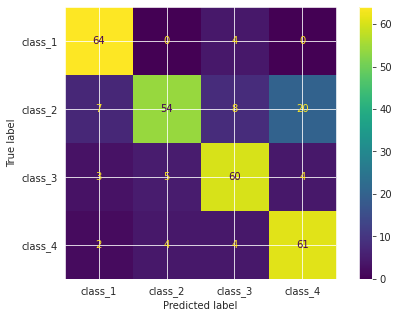

In [5]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3", "class_4"],
)

cmp.plot(ax=ax)
plt.show();

# Binary classifiers with one-vs-one (ovo) strategy

In [7]:
# Don't have to set `multi_class` argument if used with OVOClassifier
ovo = OneVsOneClassifier(estimator=GaussianProcessClassifier())

ovo.fit(X_train, y_train)
OneVsOneClassifier(estimator=GaussianProcessClassifier())

OneVsOneClassifier(estimator=GaussianProcessClassifier())

# Binary classifiers with one-vs-rest (ovr) strategy

In [9]:
# Init/fit
ovr = OneVsRestClassifier(estimator=Perceptron())
_ = ovr.fit(X_train, y_train)
print(len(ovr.estimators_))

4


# Sample classification problem and preprocessing pipeline

In [11]:
diamonds = pd.read_csv("datasets/diamonds.csv").drop("Unnamed: 0", axis=1)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [12]:
diamonds.shape

(53940, 10)

In [14]:
diamonds.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.798,0.474,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749,1.433,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457,2.234,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.800,3989.440,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731,1.122,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.735,1.142,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.539,0.706,0.0,2.91,3.53,4.04,31.80


In [15]:
diamonds.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

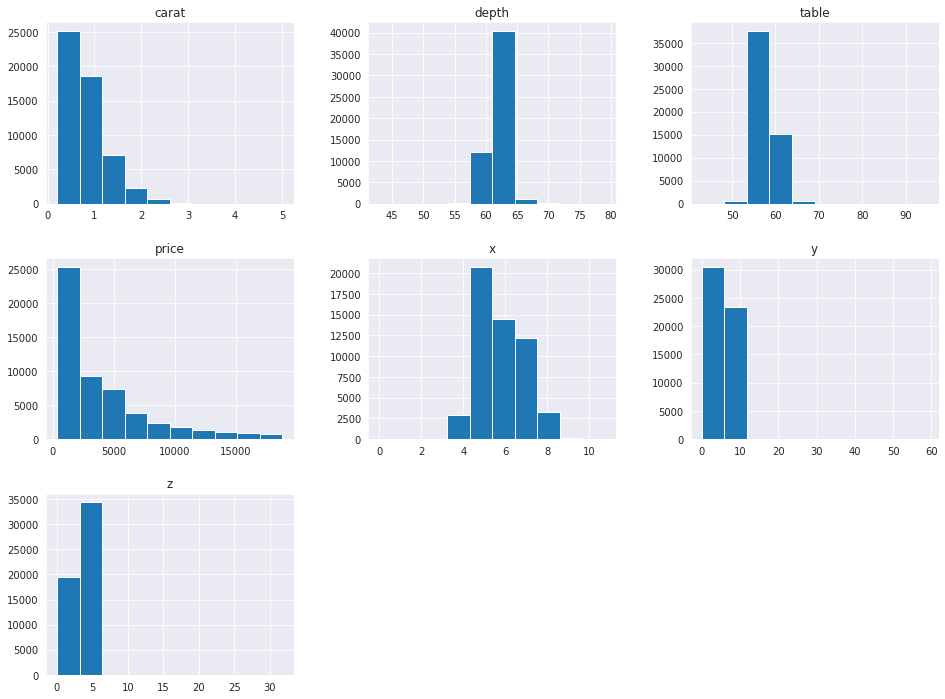

In [16]:
diamonds.hist(figsize=(16, 12))

In [18]:
# Build feature/target arrays
X, y = diamonds.drop("cut", axis=1), diamonds["cut"].values.flatten()

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1121218, test_size=0.33, stratify=y
)

In [20]:
# Build categorical preprocessor
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown="ignore")
)

# Build numeric processor
to_log = ["price", "carat"]
to_scale = ["x", "y", "z", "depth", "table"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Full processor
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale),
    ]
)

# Final pipeline combined with RandomForest
pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            RandomForestClassifier(max_depth=13),
        ),
    ]
)
# Fit
_ = pipeline.fit(X_train, y_train)

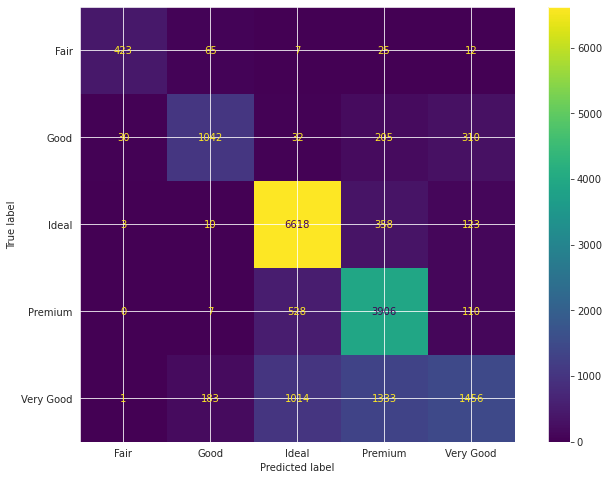

In [22]:
y_pred = pipeline.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)

plt.show();

# How Sklearn computes multiclass classification metrics — ROC AUC score

In [24]:
# Generate membership scores with .predict_proba
y_pred_probs = pipeline.predict_proba(X_test)

# Calculate ROC_AUC
roc_auc_score(
    y_test, y_pred_probs, multi_class="ovr", average="weighted"
)

0.9112702745967007

In [26]:
# GENERATE ROC_AUC SCORE FOR 'IDEAL' CLASS DIAMONDS

# Find the index of Ideal class diamonds
idx = np.where(pipeline.classes_ == "Ideal")[0][0]

# Don't have to set multiclass and average params
roc_auc_score(y_test == "Ideal", y_pred_probs[:, idx])

0.9430706861894861

# Precision, Recall and F1 scores for multiclass classification

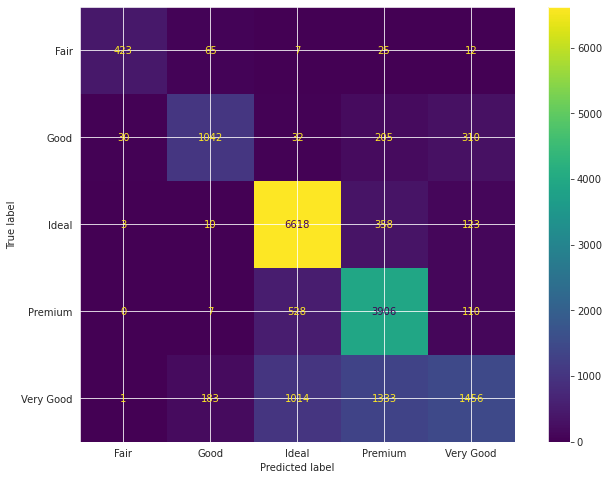

In [27]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)

plt.show();

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Fair       0.93      0.80      0.86       532
        Good       0.80      0.64      0.71      1619
       Ideal       0.81      0.93      0.86      7112
     Premium       0.67      0.86      0.75      4551
   Very Good       0.72      0.37      0.49      3987

    accuracy                           0.76     17801
   macro avg       0.78      0.72      0.73     17801
weighted avg       0.76      0.76      0.74     17801



In [31]:
# Weighed F1 across all classes
f1_score(y_test, y_pred, average="weighted")

0.7369114487892157

In [32]:
# F1 score for Ideal and Premium with weighted average
f1_score(
    y_test, y_pred, labels=["Premium", "Ideal"], average="weighted"
)

0.8208784137536613

# Hyperparameter tuning to optimize model performance for a custom metric

In [33]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3, 4]

param_grid = {
    "base__n_estimators": n_estimators,
    "base__max_depth": max_depth,
    "base__min_samples_split": min_samples_split,
    "base__min_samples_leaf": min_samples_leaf,
}

In [35]:
custom_f1 = make_scorer(
    f1_score, greater_is_better=True, average="weighted", labels=["Ideal", "Premium"]
)

custom_f1

make_scorer(f1_score, average=weighted, labels=['Ideal', 'Premium'])

In [37]:
hrs = HalvingRandomSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring=custom_f1,
    cv=3,
    n_candidates="exhaust",
    factor=5,
    n_jobs=-1,
)
# Fit
_ = hrs.fit(X, y)

# Score
best_estimator = hrs.best_estimator_
_ = best_estimator.fit(X_train, y_train)
y_preds = best_estimator.predict(X_test)

f1_score(y_test, y_preds, average="weighted", labels=["Ideal", "Premium"])

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1760 is smaller than n_iter=1798. Running 1760 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8137202412499862

In [38]:
hrs.best_score_

0.6022635129532152